## Preliminaries

In [1]:
import pandas as pd
import numpy as np
import PyPDF2
#import textract
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

## Reading Text

- converted PDF file to txt format for better pre-processing

In [8]:
filename ='JavaBasics-notes.pdf' 

pdfFileObj = open(filename,'rb')               #open allows you to read the file
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)   #The pdfReader variable is a readable object that will be parsed
num_pages = pdfReader.numPages                 #discerning the number of pages will allow us to parse through all the pages


count = 0
text = ""
                                                            
while count < num_pages:                       #The while loop will read each page
    pageObj = pdfReader.getPage(count)
    count +=1
    text += pageObj.extractText()
    
#Below if statement exists to check if the above library returned #words. It's done because PyPDF2 cannot read scanned files.

if text != "":
    text = text
    
#If the above returns as False, we run the OCR library textract to #convert scanned/image based PDF files into text

else:
    text = textract.process('http://bit.ly/epo_keyword_extraction_document', method='tesseract', language='eng')

    # Now we have a text variable which contains all the text derived from our PDF file.

In [9]:
text = text.encode('ascii','ignore').lower() #Lowercasing each word

In [10]:
text = text.decode('utf-8')

## Extracting Keywords

In [11]:
keywords = re.findall(r'[a-zA-Z]\w+',text)
len(keywords)                               #Total keywords in document

3410

In [12]:
stop_words = stopwords.words('english')
#We create a list comprehension which only returns a list of words #that are NOT IN stop_words and NOT IN punctuations.

keywords2 = [word for word in keywords if not word in stop_words]

In [13]:
len(keywords2)

2315

In [14]:
df = pd.DataFrame(list(set(keywords2)),columns=['keywords'])  #Dataframe with unique keywords to avoid repetition in rows
df.head(10)

,keywords
0,definition
1,argument
2,thread
3,end
4,codebutton
5,cloneable
6,note
7,leaks
8,notices
9,written


## Calculating Weightage

 - In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. 

- __TF: Term Frequency__, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

__TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).__

- __IDF: Inverse Document Frequency__, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

__IDF(t) = log_e(Total number of documents / Number of documents with term t in it).__

In [15]:
def weightage(word,text,number_of_documents=1):
    word_list = re.findall(word,text)
    number_of_times_word_appeared =len(word_list)
    tf = number_of_times_word_appeared/float(len(text))
    idf = np.log((number_of_documents)/float(number_of_times_word_appeared))
    tf_idf = tf*idf
    return number_of_times_word_appeared,tf,idf ,tf_idf    

In [16]:
df['number_of_times_word_appeared'] = df['keywords'].apply(lambda x: weightage(x,text)[0])
df['tf'] = df['keywords'].apply(lambda x: weightage(x,text)[1])
df['idf'] = df['keywords'].apply(lambda x: weightage(x,text)[2])
df['tf_idf'] = df['keywords'].apply(lambda x: weightage(x,text)[3])

In [17]:
df = df.sort_values('tf_idf',ascending=True)
df.to_csv('Keywords.csv')
df.head(15)

,keywords,number_of_times_word_appeared,tf,idf,tf_idf
177,java,135,0.005456,-4.905275,-0.026763
83,int,104,0.004203,-4.644391,-0.019521
28,com,67,0.002708,-4.204693,-0.011385
137,data,62,0.002506,-4.127134,-0.010341
242,applet,57,0.002304,-4.043051,-0.009314
819,obj,56,0.002263,-4.025352,-0.009110
851,hi,56,0.002263,-4.025352,-0.009110
806,object,53,0.002142,-3.970292,-0.008504
33,new,52,0.002102,-3.951244,-0.008304
29,basic,50,0.002021,-3.912023,-0.007905


In [18]:
df1 = df[['keywords','tf_idf']]
df1.head()

,keywords,tf_idf
177,java,-0.026763
83,int,-0.019521
28,com,-0.011385
137,data,-0.010341
242,applet,-0.009314


## Second Method - Using Gensim library

In [19]:
from gensim.summarization import keywords
import warnings
warnings.filterwarnings("ignore")

In [20]:
values = keywords(text=text,split='\n',scores=True)

In [21]:
data = pd.DataFrame(values,columns=['keyword','score'])
data = data.sort_values('score',ascending=False)
data.head(15)

,keyword,score
0,java basics,0.310974
2,applet,0.247484
1,applets,0.247484
3,method,0.246466
4,methods,0.246466
5,class,0.222335
6,classes,0.222335
7,objects,0.189255
8,object,0.189255
10,program,0.161004


***

In [22]:
df1 = data[['keyword','score']]

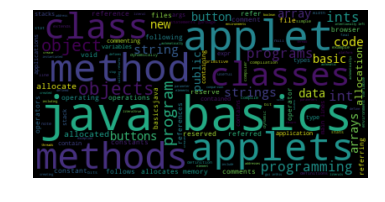

In [24]:
d = {}
for a, x in df1.values:
    d[a] = x

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

***